In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics 
import math
from statistics import median
import sqlite3, pandas as pd

#Create a database and connect to it
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()


#Create a database and connect to it
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)


# Part 1
# Problem 1
#Use multiple left joins which means payroll data before 1985 will be missing
#Leave as NaN so it can be filled later if data is found 
query = """WITH tempTable
AS (WITH tempTable2 
    AS (SELECT Salaries.yearID, Salaries.teamID, SUM(Salaries.salary) as total_payroll
        FROM Salaries
        GROUP BY Salaries.yearID, Salaries.teamID)
    SELECT Teams.yearID, Teams.teamID, Teams.franchID, tempTable2.total_payroll, (CAST(Teams.W as REAL) / Teams.G * 100) as win_per, Teams.W, Teams.G
    FROM Teams
    LEFT JOIN tempTable2
    ON tempTable2.yearID = Teams.yearID AND tempTable2.teamID = Teams.teamID)
SElECT Teams.yearID, Teams.franchID, Teams.teamID, tempTable.total_payroll, tempTable.win_per
FROM Teams
LEFT JOIN tempTable
ON (tempTable.yearID = Teams.yearID AND tempTable.teamID = Teams.teamID)"""

df = pd.read_sql(query, conn)



display(df)

,yearID,franchID,teamID,total_payroll,win_per
0,1871,BNA,BS1,NaN,64.516129
1,1871,CNA,CH1,NaN,67.857143
2,1871,CFC,CL1,NaN,34.482759
3,1871,KEK,FW1,NaN,36.842105
4,1871,NNA,NY2,NaN,48.484848
...,...,...,...,...,...
2770,2014,PIT,PIT,77178000.0,54.320988
2771,2014,SDP,SDN,75685700.0,47.530864
2772,2014,SFG,SFN,20000000.0,54.320988
2773,2014,STL,SLN,120693000.0,55.555556


Part 1: Problem 1 Writeup


I query using SQL to extract the data from the SQLite database and into a pandas dataframe. To do this, I use multiple left joins from the Salaries and Teams tables in the database. However, since the range of years isn't the same between tables, teams between 1871 and 1984 do not have payroll data and is left as NaN. Additionally, I chose to use franchID over teamID since it's common for teams to change city but it's uncommon for franchises to disband entirely. 

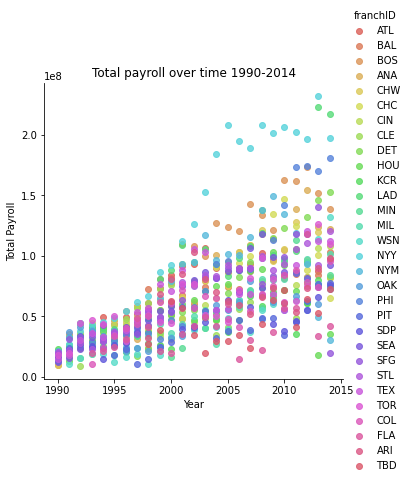

In [22]:
# Part 2
# Problem 2


#Get the total payroll for each year and team combination, store it in pandas dataframe
salary_query = "WITH tempTable AS (SELECT Salaries.yearID, Salaries.teamID, Teams.franchID, SUM(Salaries.salary) as total_payroll FROM Salaries, Teams WHERE Salaries.teamID = Teams.teamID AND Salaries.yearID = Teams.yearID AND Salaries.yearID >= 1990 AND Salaries.yearID <= 2014 GROUP BY Salaries.yearID, Salaries.teamID) SELECT * FROM tempTable"
sal_df = pd.read_sql(salary_query, conn)

#Create a scatter plot and map a color to each team 
sns.lmplot(x="yearID", y="total_payroll", data=sal_df, fit_reg=False, hue='franchID', legend=True, palette=sns.color_palette("hls", len(sal_df.franchID.unique())))
plt.xlabel("Year")
plt.ylabel("Total Payroll")
plt.title("Total payroll over time 1990-2014")
plt.show()

Part 2: Problem 2 Writeup

I query the SQLite database to get the total payroll for each team between 1990 to 2014 and store it in a pandas dataframe. I create a scatter plot where each franchise gets a unique color. Although some colors aren't visually distinct from others, the plot is useful as it shows how centrality and spread change over time.

Part 2: Question 1


What statements can you make about the distribution of payrolls conditioned on time based on these plots? 
            Since 1990, the spread between the distribution of payrolls for each franchise has dramtically increased. For the first few seasons, the distribution is relatively uniform which can be seen by the lack of outliers and how tightly packed together the points are. Beginning in the late 1990s and early 2000s however, certain teams began to spend more and more salary year over year. Although the median was certainly increasing during these years, some teams couldn't spend at a similar rate as other teams, thus increasing "payroll inequality" across the league. In terms of skewness, the distributions become more right skewed over time, with some left skewness in more recent years.



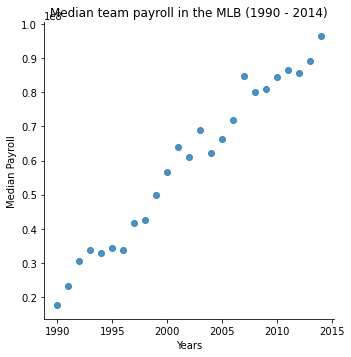

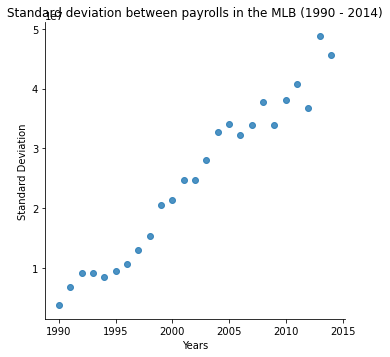

In [23]:
#Part 2
#Problem 3

#Initialize lists
med_lst = []
std_lst = []
#For every year b/w 1990 - 2014, get the total payroll of each time and find the median and std dev, store them in a list
for i in range(1990, 2015):
    lst = []    
    for ind in sal_df.index:
        if sal_df['yearID'][ind] == i:
            lst.append(sal_df['total_payroll'][ind])
    [int(a) for a in lst]
    lst.sort()
    med = median(lst)
    sd = statistics.stdev(lst)
    med_lst.append(med)
    std_lst.append(sd)
#Store std dev list in a DataFrame
std_payroll = pd.DataFrame()
std_payroll['std_payroll'] = std_lst

#Store median list in a DataFrame
med_payroll = pd.DataFrame()
med_payroll['median_payroll'] = med_lst

#Get a list of every year b/w 1990 - 2014
year_lst = [i for i in range(1990,2015)]

#Add year_lst to each DataFrame
med_payroll['yearID'] = year_lst
std_payroll['yearID'] = year_lst

#Plot the median payroll data, the standard deviation payroll data, and the distribution of payrolls over time
sns.lmplot(x="yearID",y="median_payroll", data=med_payroll, fit_reg=False)
plt.title("Median team payroll in the MLB (1990 - 2014)")
plt.xlabel("Years")
plt.ylabel("Median Payroll")
plt.show()
sns.lmplot(x="yearID",y="std_payroll", data=std_payroll, fit_reg=False)
plt.title("Standard deviation between payrolls in the MLB (1990 - 2014)")
plt.xlabel("Years")
plt.ylabel("Standard Deviation")
plt.show()

Part 2: Problem 3 Writeup

For each year, I take every team's total payroll data and compute the standard deviation and mean payroll.

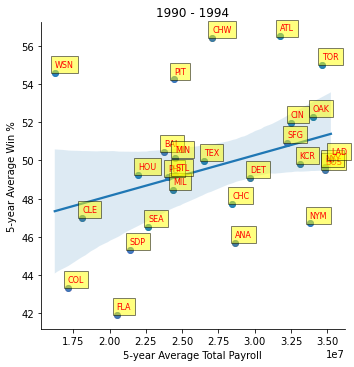

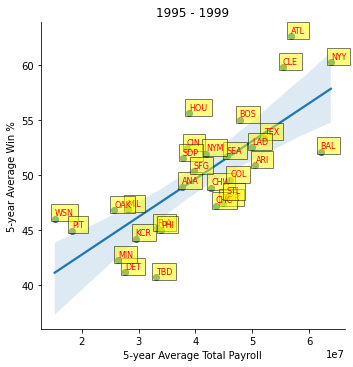

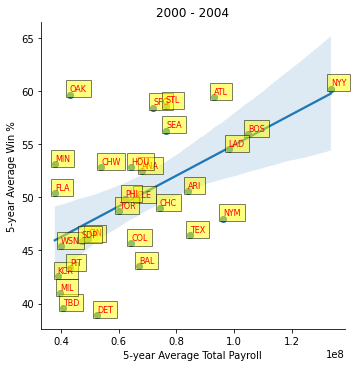

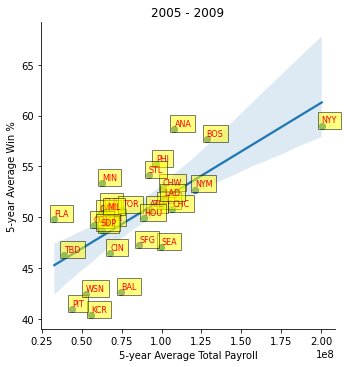

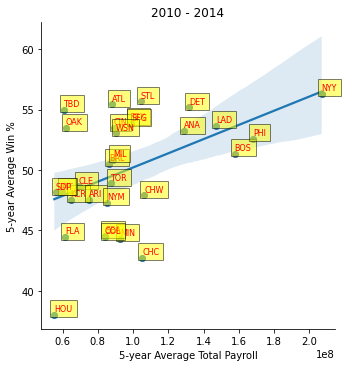

In [24]:
#Part 2
#Problem 4
time_periods = pd.cut(np.array([i for i in range (1990,2015)]), 5)

time_periods = time_periods.unique()
#print(time_periods)

#temp = df.franchID.tolist()


franchID_periods = []
for per in time_periods:
    franch_lst2 = []
    lst = []
    for ind, row in df.iterrows():
        if row['yearID'] in per:
           lst.append(row['franchID'])    
    [franch_lst2.append(x) for x in lst if x not in franch_lst2]
    franchID_periods.append(franch_lst2)

df_mast = []
years = []
df_90to14 = df.loc[df['yearID'] > 1989]
for i in range(5):
    df_temp = pd.DataFrame()
    franch_temp = []
    
    mean_pay_temp = []
    mean_win_temp = []
    per = time_periods[i]
    iv = str(math.ceil(per.left)) + " - " + str(math.floor(per.right))
    years.append(iv)
    
    for franch in franchID_periods[i]:
        franch_temp.append(franch)
        franch_per_pay_lst = []
        franch_per_win_lst = []
        for index, row in df_90to14.iterrows():
            if row['yearID'] in per and row['franchID'] == franch:
                franch_per_pay_lst.append(row['total_payroll'])                
                franch_per_win_lst.append(row['win_per'])
        mean_pay_temp.append(statistics.mean(franch_per_pay_lst))
        mean_win_temp.append(statistics.mean(franch_per_win_lst))

    df_temp['franchID'] = franch_temp
    df_temp['mean_payroll'] = mean_pay_temp
    df_temp['mean_win_per'] = mean_win_temp
    df_mast.append(df_temp)

for i in range(5):
    df_temp = df_mast[i]
    sns.lmplot(x="mean_payroll", y="mean_win_per", data=df_temp, fit_reg=False, hue='franchID', legend=False).set(title=years[i])
    for i in range(df_temp.shape[0]):
        plt.text(x=df_temp.mean_payroll[i]+0.3,y=df_temp.mean_win_per[i]+0.3,s=df_temp.franchID[i], 
          fontdict=dict(color='red',size=8),
          bbox=dict(facecolor='yellow',alpha=0.5))
    sns.regplot(x="mean_payroll", y="mean_win_per", data=df_temp)
    plt.ylabel("5-year Average Win %")
    plt.xlabel("5-year Average Total Payroll")
    plt.show()

Part 2: Problem 4 Writeup

For each franchise I get the average total payroll and the average win percentage during each period. I then plot every team in respect to average payroll and average win percentage for a given period. For clarity, I include the franchID as a label for each point along with the regression line.

Part 2: Question 2

What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods 

Generally, there is a strong correlation between a larger payroll with a higher winning percentage across the five periods. The correlation is less strong in the first period (1990-1994) but becomes stronger over time. Some of the teams that best demonstrate this correlation between payroll and win percentage are the Atlanta Braves, the New York Yankees, and the Boston Red Sox. However, over time it seems that more and more teams exceed their expected win percentage (based off their payroll). The 2000-2004 Oakland A's are the best example of this, as despite having less than 1/3 the payroll of the best team in baseball, the Yankees, the A's match their win percentage. Some other outlirs are the 1990-1994 Washington Nationals, the 2005-2009 Los Angeles Angels, and the 2010-2014 Tampa Bay Rays. However, the A's are an interesting case when analyizing spending efficiency because they were one of the more typical franchises during the first two periods of this analysis (1990-1994, 1995-1999). During the first period, the A's had one of the highest payrolls in baseball and they won more games than almost anyone. However, the next period, 1995-1999, saw their payroll decrease with their win percentage. However, during the 2000-2004 period, something within the A's organization changed, as they began to have success in spite of their small payroll. For the most part, they continued this trend during the next two periods, 2005-2009 and 2010-2014. 

In [25]:
#Problem 3
#Part 5
df_90to14 = df.loc[df['yearID'] > 1989]
df_90to14 = df_90to14.reset_index()
df_90to14 = df_90to14.drop(columns=['index'])
avg_payroll_by_year = []
std_dev_payroll_by_year = []
years = [i for i in range(1990,2015)]
for year in years:
    lst = []
    for index, row in df_90to14.iterrows():
        if row['yearID'] == year:
            lst.append(df_90to14.at[index,'total_payroll'])
    avg_payroll_by_year.append(statistics.mean(lst))
    std_dev_payroll_by_year.append(statistics.stdev(lst))
df_std_payroll = pd.DataFrame()
df_std_payroll['Year'] = years
df_std_payroll['Average Payroll'] = avg_payroll_by_year
df_std_payroll['Std Dev Payroll'] = std_dev_payroll_by_year
display(df_std_payroll)
def standardized_payroll(tot_payroll, avg_payroll, stdev_payroll):
    return ((tot_payroll - avg_payroll) / stdev_payroll)
std_payroll_lst = []
for i,row1 in df_std_payroll.iterrows(): 
    for j, row2 in df_90to14.iterrows():
        if row1['Year'] == row2['yearID']:
            std_payroll_lst.append(standardized_payroll(row2['total_payroll'], row1['Average Payroll'], row1['Std Dev Payroll']))
            
df_90to14['standardized_payroll'] = std_payroll_lst
display(df_90to14)

,Year,Average Payroll,Std Dev Payroll
0,1990,1.707235e+07,3.771834e+06
1,1991,2.357879e+07,6.894669e+06
2,1992,3.098244e+07,9.150607e+06
3,1993,3.220500e+07,9.232485e+06
4,1994,3.313701e+07,8.528749e+06
5,1995,3.398105e+07,9.447998e+06
6,1996,3.417798e+07,1.068853e+07
7,1997,4.026021e+07,1.306073e+07
8,1998,4.260943e+07,1.538081e+07
9,1999,4.980762e+07,2.056133e+07


,yearID,franchID,teamID,total_payroll,win_per,standardized_payroll
0,1990,BAL,BAL,9680084.0,47.204969,-1.959861
1,1990,BOS,BOS,20558333.0,54.320988,0.924213
2,1990,ANA,CAL,21720000.0,49.382716,1.232198
3,1990,CHW,CHA,9491500.0,58.024691,-2.009859
4,1990,CLE,CLE,14487000.0,47.530864,-0.685437
...,...,...,...,...,...,...
723,2014,PIT,PIT,77178000.0,54.320988,-0.494957
724,2014,SDP,SDN,75685700.0,47.530864,-0.527607
725,2014,SFG,SFN,20000000.0,54.320988,-1.745978
726,2014,STL,SLN,120693000.0,55.555556,0.457126


Part 3: Problem 5 Writeup

For each year, I find the average payroll and standard deviation. Using this data, I calculate the standardized payroll for each team between 1990 to 2014.


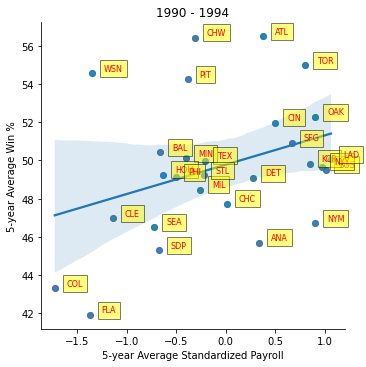

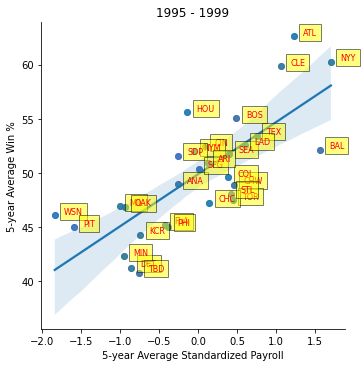

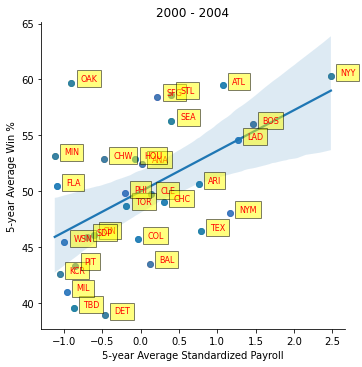

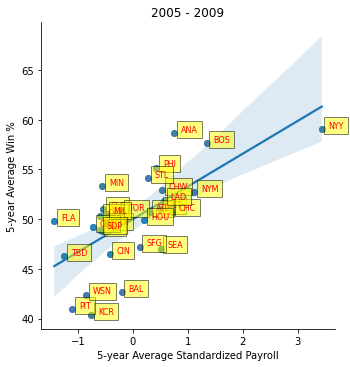

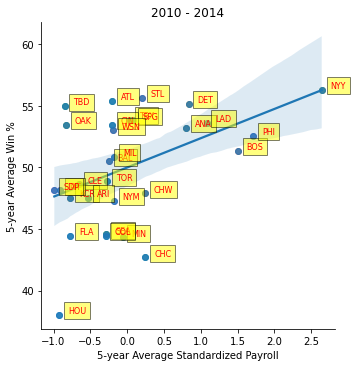

In [26]:
#Problem 3
#Part 6
df_mast = []
years = []
for i in range(5):
    df_temp = pd.DataFrame()
    franch_temp = []
    
    mean_pay_temp = []
    mean_win_temp = []
    per = time_periods[i]
    iv = str(math.ceil(per.left)) + " - " + str(math.floor(per.right))
    years.append(iv)
    
    for franch in franchID_periods[i]:
        franch_temp.append(franch)
        franch_per_pay_lst = []
        franch_per_win_lst = []
        for index, row in df_90to14.iterrows():
            if row['yearID'] in per and row['franchID'] == franch:
                franch_per_pay_lst.append(row['standardized_payroll'])                
                franch_per_win_lst.append(row['win_per'])
        mean_pay = sum(franch_per_pay_lst) / len(franch_per_pay_lst)
        mean_win = sum(franch_per_win_lst) / len(franch_per_win_lst)
        mean_pay_temp.append(mean_pay)
        mean_win_temp.append(mean_win)

    df_temp['franchID'] = franch_temp
    df_temp['mean_payroll'] = mean_pay_temp
    df_temp['mean_win_per'] = mean_win_temp
    df_mast.append(df_temp)
    

for i in range(5):
    df_temp = df_mast[i]
    sns.lmplot(x="mean_payroll", y="mean_win_per", data=df_temp, fit_reg=False, hue='franchID', legend=False).set(title=years[i])
    for i in range(df_temp.shape[0]):
        plt.text(x=df_temp.mean_payroll[i]+0.12,y=df_temp.mean_win_per[i]+0.12,s=df_temp.franchID[i], 
          fontdict=dict(color='red',size=8),
          bbox=dict(facecolor='yellow',alpha=0.5))
    sns.regplot(x="mean_payroll", y="mean_win_per", data=df_temp)    
    plt.ylabel("5-year Average Win %")
    plt.xlabel("5-year Average Standardized Payroll")
    plt.show()


Part 3: Probem 6 Writeup

I create the same plot from part 4 but now use the standardized payroll metric I created in the last problem.

Part 3: Question 3

The transformation adjusts the team payroll to be relative to the period. Thus, we have a better way of comparing teams across eras since they payroll has the same units. 

2.7251036461557065 49.98855314843013


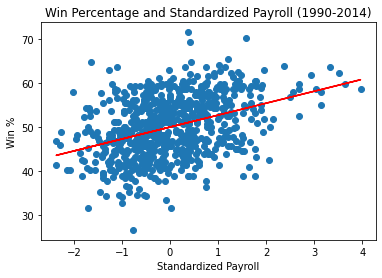

,yearID,franchID,teamID,total_payroll,win_per,standardized_payroll,exp_wins
0,1990,BAL,BAL,9680084.0,47.204969,-1.959861,44.708376
1,1990,BOS,BOS,20558333.0,54.320988,0.924213,52.495376
2,1990,ANA,CAL,21720000.0,49.382716,1.232198,53.326934
3,1990,CHW,CHA,9491500.0,58.024691,-2.009859,44.573382
4,1990,CLE,CLE,14487000.0,47.530864,-0.685437,48.149321
...,...,...,...,...,...,...,...
723,2014,PIT,PIT,77178000.0,54.320988,-0.494957,48.663617
724,2014,SDP,SDN,75685700.0,47.530864,-0.527607,48.575461
725,2014,SFG,SFN,20000000.0,54.320988,-1.745978,45.285860
726,2014,STL,SLN,120693000.0,55.555556,0.457126,51.234241


In [27]:
#Part 3
#Problem 7
array = df_90to14.to_numpy()
y = array[:,4]
y = y.astype(str).astype(float)
x = array[:,5]
x = x.astype(str).astype(float)
slope, intercept = np.polyfit(x, y, deg=1)
print(slope, intercept)
plt.scatter(df_90to14['standardized_payroll'], df_90to14['win_per'])
plt.plot(df_90to14['standardized_payroll'], df_90to14['standardized_payroll']*slope + intercept, 'r')
plt.title("Win Percentage and Standardized Payroll (1990-2014)")
plt.xlabel("Standardized Payroll")
plt.ylabel("Win %")
plt.show()
exp_wins_lst = []
for ind, row in df_90to14.iterrows():
    exp_wins_lst.append(50 + 2.7 * row['standardized_payroll'])
df_90to14['exp_wins'] = exp_wins_lst
display(df_90to14)

Part 3: Problem 7 Writeup

I find the line of regression for standardized payroll and win percentage. From this, I can find the expected wins using the formula 50 + 2.7 * standardized_payroll for each team and create a scatter plot of win percentage and standardized payroll.

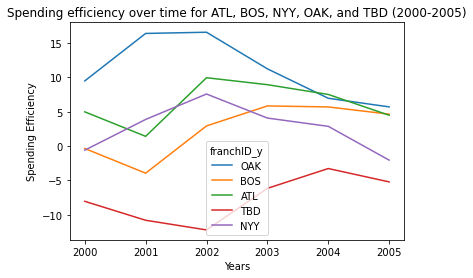

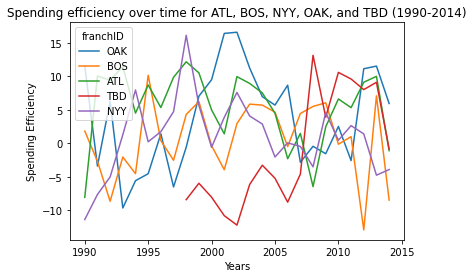

In [28]:
#Part 3
#Problem 8

eff_lst = []
for ind, row in df_90to14.iterrows():
    eff_lst.append(row['win_per'] - row['exp_wins'])
df_90to14['eff'] = eff_lst

df_90to14_oak =  df_90to14.loc[(df_90to14['franchID'] == "OAK")]
df_90to14_bos =  df_90to14.loc[(df_90to14['franchID'] == "BOS")]
df_90to14_atl =  df_90to14.loc[(df_90to14['franchID'] == "ATL")]
df_90to14_tbd =  df_90to14.loc[(df_90to14['franchID'] == "TBD")]
df_90to14_nyy =  df_90to14.loc[(df_90to14['franchID'] == "NYY")]
frames = [df_90to14_oak, df_90to14_bos, df_90to14_atl, df_90to14_tbd, df_90to14_nyy]
result = pd.concat(frames)
result = result.reset_index()
result = result.drop(columns=['index'])
df_90to14 = df.loc[df['yearID'] > 1989]
result_temp1 = result.loc[result['yearID'] >= 2000]
result_temp2 = result.loc[result['yearID'] <= 2005]
#merged_inner = pd.merge(left=survey_sub, right=species_sub, left_on='species_id', right_on='species_id')
result_inner = pd.merge(left=result_temp1, right=result_temp2, left_on='yearID', right_on='yearID')
result_inner = result_inner.drop(columns=['exp_wins_x','teamID_x', 'franchID_x', 'total_payroll_x', 'win_per_x', 'standardized_payroll_x', 'eff_x'] )
result_inner = result_inner.drop_duplicates()
sns.lineplot(x="yearID", y="eff_y", data=result_inner, hue="franchID_y")
plt.title("Spending efficiency over time for ATL, BOS, NYY, OAK, and TBD (2000-2005)")
plt.xlabel("Years")
plt.ylabel("Spending Efficiency")
plt.show()
sns.lineplot(x="yearID", y="eff", data=result, hue="franchID")
plt.title("Spending efficiency over time for ATL, BOS, NYY, OAK, and TBD (1990-2014)")
plt.xlabel("Years")
plt.ylabel("Spending Efficiency")
plt.show()
result_most_eff = result.loc[result['eff'] > 11]
result_most_eff = result_most_eff.reset_index()
result_most_eff = result_most_eff.drop(columns=['index'])

Part 3: Problem 8 Writeup

I first calculate the expected wins for every team between 1990 to 2014. Then, I select five franchises to anaylze in depth and plot their spending efficiency for 2000 - 2005 and 1990 - 2014 where the former represents the "Moneyball Era".

In [ ]:
conn.close()

Part 3: Question 4

The plots in questions 2 and 3 shows the correlation between payroll and win percentage. From this, we can see that the winningest teams in baseball are those that spend the most money. However, we also notice that there are historical outliers in which some of the best teams spent very little. So, if we're able to quantify how well teams spend on wins, we can compare franchises on their ability to evaluate talent. The more successful a team is at identifying winning players, the higher their efficiency is. For instance, despite NYY having a comparable win percentage to OAK, New York is much worse when it comes to spending their money efficienctly.

Between 2000 and 2005, the Oakland A's had an unprecedented efficiency when it came to converting dollars to wins. Their average efficiency during this period was 11.06, a mark no other team came close to in a single season. In fact, only  four other teams have put up an efficiency score above 11 between 1990 to 2014 and of the ten highest efficiency scores on reocrd, six belong to the Oakland A's.  